
---

# A) Step-by-step in your current B4b (sampling ECAL) setup

1. **Produce runs at several beam energies**
   Run `exampleB4b.py` in batch mode for (E={1,2,5,10,20,50},\text{GeV}) (or your list), saving one ROOT file per energy (you’re already renaming `B4.root` to `B4_<E>GeV.root` after each run).

2. **Choose what you call “measured energy”**
   For a sampling ECAL the readout is the **active medium**. From each ROOT file read **`Egap`** (energy deposited in the gap) **per event**. That’s your event-wise observable (E_{\text{meas}}).

3. **Build the per-energy response**
   For each beam energy (E_{\text{beam}}), make the distribution of (E_{\text{meas}}) over events.

   * Prefer a **Gaussian fit** (mean (\mu), width (\sigma)) to the core of the spectrum. If you just take sample mean/std it’s usually fine for clean, symmetric distributions; CMS used a Gaussian + polynomial tail to be robust to low-energy tails. 
   * Compute the **resolution** (R=\sigma/\mu).

4. **Fit the resolution curve**
   If you did not simulate electronics noise, use the 2-term model
   [
   R(E)=\sqrt{\frac{S^2}{E}+C^2}.
   ]
   (With no electronics, the (N/E) term is effectively zero.) Fit (S) (stochastic) and (C) (constant).
   Tip: Linearize as (R^2 = (S^2),(1/E) + C^2) and do a straight-line fit vs (1/E).

5. **Report**
   Quote (S) as “(S\times100%\cdot\sqrt{\text{GeV}})” and (C) as a percent. Plot (R(E)) with the fit curve.

> This matches the **physics meaning** of energy resolution and is fully consistent for your B4b study. What it does **not** include (yet) is CMS’s leakage correction and explicit electronics noise treatment, which are experiment-specific refinements. 



The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.

**************************************************************
 Geant4 version Name: geant4-11-03 [MT]   (6-December-2024)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Geant4 Physics List simulation engine: FTFP_BERT

Using Root

-------- WWWW ------- G4Exception-START -------- WWWW -------
*** G4Exception : Analysis_W001
      issued by : G4RootNtupleFileManager::SetNtupleMergingMode
Merging ntuples is not applicable in sequential application.
Setting was ignored.
*** This is just a warning message. ***
-------- WWWW -------- G

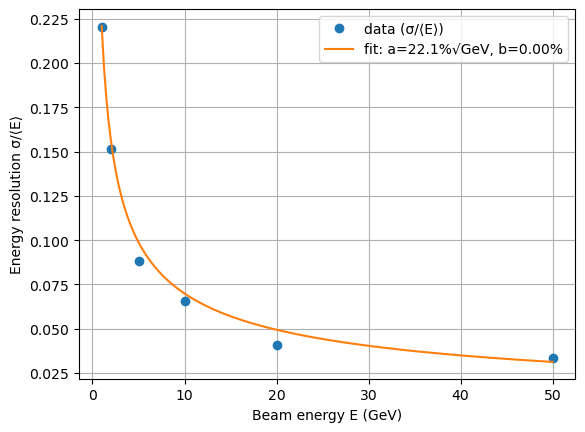

In [1]:
import subprocess, shutil, pathlib, textwrap, os
import uproot
import numpy as np
import matplotlib.pyplot as plt

# ---- CONFIG ----
EXE = "exampleB4d.py"     # <- use the B4d example
N_EVENTS = 100           # bump stats for smoother σ/E
energies_GeV = [1, 2, 5, 10, 20, 50]

# ---- RUN ONE ENERGY AND RENAME OUTPUT ----
def run_one_energy(E):
    mac = pathlib.Path(f"run_{E}GeV.mac")
    mac.write_text(textwrap.dedent(f"""
        /run/initialize
        /gun/particle e-
        /gun/energy {E} GeV
        /run/printProgress 1000
        /run/beamOn {N_EVENTS}
    """).strip())

    # ensure no leftover file from previous run
    if pathlib.Path("B4.root").exists():
        os.remove("B4.root")

    # run the example in batch mode with this macro
    subprocess.run(["python", EXE, "-m", str(mac)], check=True)

    # the example writes B4.root; rename to per-energy file
    src = pathlib.Path("B4.root")
    if not src.exists():
        raise FileNotFoundError("Expected B4.root not found. Did the run finish?")
    dst = pathlib.Path(f"B4_{E}GeV.root")
    shutil.move(str(src), str(dst))
    return str(dst)

# run all energies
roots = [run_one_energy(E) for E in energies_GeV]
print("Wrote:", roots)

# ---- LOAD Edep IN GAP (VISIBLE ENERGY) ----
def load_edep_gap(root_path):
    with uproot.open(root_path) as f:
        t = f["B4"]                    # TTree name
        Egap = t["Egap"].array(library="np")  # MeV
    return Egap

means, sigmas, resolutions = [], [], []
for E, rfile in zip(energies_GeV, roots):
    Egap = load_edep_gap(rfile)       # MeV per event
    mu   = Egap.mean()                # MeV
    sig  = Egap.std(ddof=1)           # MeV
    R    = sig / mu                   # dimensionless
    means.append(mu)
    sigmas.append(sig)
    resolutions.append(R)

means  = np.array(means)
sigmas = np.array(sigmas)
R      = np.array(resolutions)
E      = np.array(energies_GeV, dtype=float)

# ---- FIT R(E) = sqrt(a^2/E + b^2) VIA LINEARIZATION ----
x = 1.0 / E
y = R**2
A = np.vstack([x, np.ones_like(x)]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]  # y ≈ m x + c
a = float(np.sqrt(max(m, 0.0)))  # stochastic term (√GeV units)
b = float(np.sqrt(max(c, 0.0)))  # constant term

print(f"a = {a*100:.1f}%·√GeV")
print(f"b = {b*100:.2f}%")

# ---- PLOT ----
E_dense = np.linspace(E.min(), E.max(), 200)
R_fit = np.sqrt( (a*a)/E_dense + b*b )

plt.plot(E, R, "o", label="data (σ/⟨E⟩)")
plt.plot(E_dense, R_fit, "-", label=f"fit: a={a*100:.1f}%√GeV, b={b*100:.2f}%")
plt.xlabel("Beam energy E (GeV)")
plt.ylabel("Energy resolution σ/⟨E⟩")
plt.grid(True)
plt.legend()
plt.show()


# 🧱 **B4d Calorimeter Geometry Overview**

B4d defines a **longitudinal sampling electromagnetic calorimeter**:
a stack of alternating **absorber** and **active (gap)** layers, just like B4b, but with **sensitive detectors** and **scorers** automatically attached.

---

## 🔩 **Geometric parameters (default values)**

| Quantity                     | Symbol          | Default Value         | Description                                |
| ---------------------------- | --------------- | --------------------- | ------------------------------------------ |
| Number of layers             | `nofLayers`     | 10                    | Number of absorber + gap pairs             |
| Absorber thickness           | `absoThickness` | 10 mm                 | Thickness of lead absorber per layer       |
| Gap (active layer) thickness | `gapThickness`  | 5 mm                  | Thickness of liquid argon gap per layer    |
| Calorimeter transverse size  | `calorSizeXY`   | 10 cm × 10 cm         | Square cross-section perpendicular to beam |
| World volume size            | `1.2×` larger   | 12 cm × 12 cm × 18 cm | Vacuum surrounding the calorimeter         |

---

## 🧩 **Material composition**

| Volume          | Material            | Notes                                             |
| --------------- | ------------------- | ------------------------------------------------- |
| **Absorber**    | `G4_Pb` (lead)      | Dense converter for e⁻/γ showers                  |
| **Gap**         | `liquidArgon`       | Active readout medium (collects deposited energy) |
| **World**       | `Galactic` (vacuum) | Empty container for geometry                      |
| **Calorimeter** | (composite)         | Logical container holding 10 layers               |

---

## 📐 **Structure (Z-axis stacking)**

Each layer consists of:

```
|<--- Layer (15 mm) ----------------------------->|
|                                                 |
|   [ Absorber (Pb) | 10 mm ]  +  [ Gap (LAr) | 5 mm ] |
```

Stack 10 such layers along **+z** (the beam direction), producing a total depth of **150 mm**.

### Schematic:

```
  e⁻ beam →
            |##########|-----|##########|-----|##########|-----|
            |  Pb (10) | LAr |  Pb (10) | LAr |  Pb (10) | LAr |
            |##########|-----|##########|-----|##########|-----|
                    <----------- repeated 10 times ----------->
```

---

## ⚙️ **World hierarchy**

| Level | Volume name   | Parent        | Description            |
| ----- | ------------- | ------------- | ---------------------- |
| 0     | `World`       | —             | Vacuum box             |
| 1     | `Calorimeter` | `World`       | Container of layers    |
| 2     | `Layer`       | `Calorimeter` | Replicated 10× along z |
| 3     | `Abso`        | `Layer`       | Lead absorber          |
| 3     | `Gap`         | `Layer`       | Liquid argon gap       |

---

# 🧠 **Physical meaning**

* **Absorber (Pb):** Converts incident e⁻ or γ into a cascade of secondary particles via bremsstrahlung and pair production.
* **Gap (LAr):** Collects the energy deposits of the shower particles; this “visible energy” is your calorimeter signal.
* Each layer combination corresponds to one **sampling unit**.
* Total thickness (~150 mm) gives about **15 radiation lengths**, enough to contain a several-GeV electromagnetic shower.
